## Setup and Import Packages

In [1]:
!pip install imutils


  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=638760d2b706ec5d315981521dfa01e4d3b4a4bcd438dbe991b78414ee42bab4
  Stored in directory: /root/.cache/pip/wheels/f5/0c/3a/61b992f7aa85de40f339e6d4970d91dddb103dd0ad6c5d58f2
Successfully built imutils


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50,DenseNet201,ResNet152V2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [3]:
import tensorflow as tf
random_value=42 #setting randomness at fixed for every run

## Making Dataset 

In [4]:
DIR = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


1341


In [5]:
dataset_path = './dataset'

In [6]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p dataset/generated


In [7]:
covid_dataset_path = '../input/covid-chest-xray'

In [8]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [9]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [10]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))
random.seed(random_value)
random.shuffle(imagePaths)
imagePaths = imagePaths[:127] 

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

## Plot x-rays

In [11]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [12]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

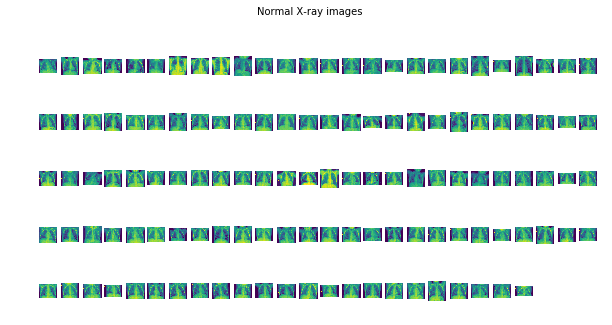

In [13]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

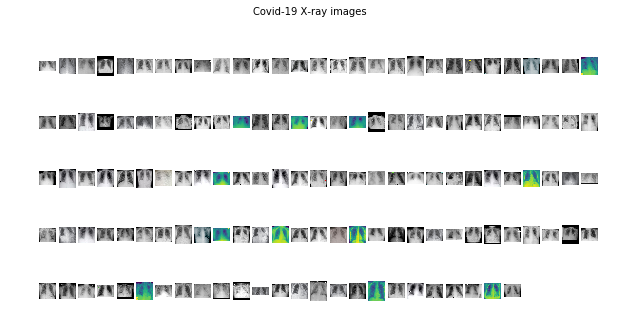

In [14]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

## Data preprocessing

In [15]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 100  #15,100
BS = 8 #8 16

In [16]:
#importing packages of keras for different aspects
from tensorflow import keras
METRICS = ["accuracy",
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [17]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
# print(len(paths.list_images(dataset_path)))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [18]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [19]:
print("Total images = {} and labels = {}".format(len(data),len(labels)))

Total images = 268 and labels = 268


## Partioning DataSet and Augmentation

In [20]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20,stratify=labels, random_state=random_value)
# initialize the training data augmentation object
print("Size of train image : {} and train label : {}".format(len(trainX),len(trainY)))
print("Size of test image : {} and test label : {}".format(len(testX),len(testY)))
trainAug = ImageDataGenerator(
    rotation_range=15, 
    fill_mode="nearest",
    shear_range=2.0,
    zoom_range=2.0,
    
    horizontal_flip=True,
    vertical_flip=True,
    

)

Size of train image : 214 and train label : 214
Size of test image : 54 and test label : 54


## Finding the distribution of covid and normal for train and test dataset

In [21]:
y_train = trainY.tolist()
print("Total data in train set : ",len(y_train))

covid=0
noncovid=0

for idx,i in enumerate(y_train):
    if(i == [1.0, 0.0]):
        covid+=1
    else:
        noncovid+=1
print("In distribution of train covid = {} and noncovid = {}".format(covid,noncovid))

y_test = testY.tolist()
print("Total data in test set : ",len(y_test))
covid=0
noncovid=0

for idx,i in enumerate(y_test):
    if(i == [1.0, 0.0]):
        covid+=1
    else:
        noncovid+=1
print("In distribution of test covid = {} and noncovid = {}".format(covid,noncovid))

Total data in train set :  214
In distribution of train covid = 113 and noncovid = 101
Total data in test set :  54
In distribution of test covid = 28 and noncovid = 26


## Model VGG16

In [22]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
# headModel = GaussianNoise(0.9)(headModel)
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Training

In [24]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=METRICS)
# train the head of the network
print("[INFO] training head...")
vgg_history = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS,save_to_dir="../working/dataset/generated/"),
    steps_per_epoch=len(trainX) // BS,
    
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,

)

[INFO] compiling model...
[INFO] training head...
Train for 26 steps, validate on 54 samples
Epoch 1/100
26/26 [==============================] - 9s 359ms/step - loss: 0.8061 - accuracy: 0.4663 - tp: 97.0000 - fp: 111.0000 - tn: 97.0000 - fn: 111.0000 - precision: 0.4663 - recall: 0.4663 - auc: 0.4609 - val_loss: 0.5496 - val_accuracy: 0.8333 - val_tp: 40.0000 - val_fp: 8.0000 - val_tn: 40.0000 - val_fn: 8.0000 - val_precision: 0.8333 - val_recall: 0.8333 - val_auc: 0.8585
Epoch 2/100
26/26 [==============================] - 5s 198ms/step - loss: 0.6478 - accuracy: 0.6408 - tp: 132.0000 - fp: 74.0000 - tn: 132.0000 - fn: 74.0000 - precision: 0.6408 - recall: 0.6408 - auc: 0.6686 - val_loss: 0.5789 - val_accuracy: 0.5625 - val_tp: 27.0000 - val_fp: 21.0000 - val_tn: 27.0000 - val_fn: 21.0000 - val_precision: 0.5625 - val_recall: 0.5625 - val_auc: 0.6810
Epoch 3/100
26/26 [==============================] - 4s 173ms/step - loss: 0.6418 - accuracy: 0.6311 - tp: 130.0000 - fp: 76.0000 - tn:

### Counting total generated images using augmentation

In [25]:
import glob
count=0
for i in glob.glob("../working/dataset/generated/*"):
    count+=1
print(count)

21295


### Plot trining metrics

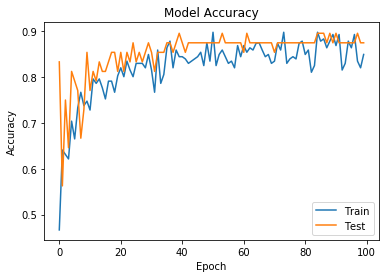

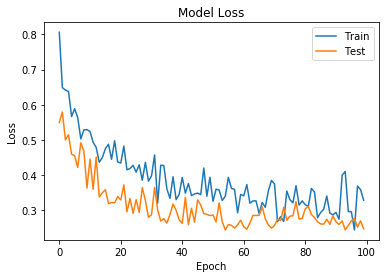

In [26]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig('vgg_model_accuracy_DataGenerator.jpeg')
plt.savefig('vgg_model_accuracy_DataGenerator.svg')
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig('vgg_model_loss_DataGenerator.jpeg')
plt.savefig('vgg_model_loss_DataGenerator.svg')
plt.show()

### Evaluation

In [27]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.92      0.82      0.87        28
      normal       0.83      0.92      0.87        26

    accuracy                           0.87        54
   macro avg       0.87      0.87      0.87        54
weighted avg       0.88      0.87      0.87        54



#### Confusion matrix

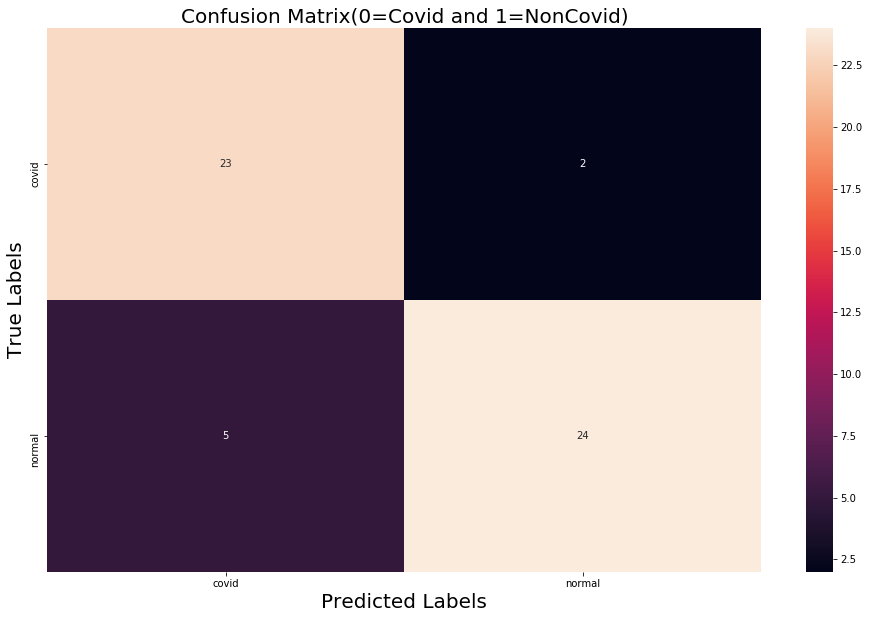

In [28]:
import seaborn as sns 
# plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(16,10))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix(0=Covid and 1=NonCovid)',size=20)
ax.xaxis.set_ticklabels(lb.classes_)
ax.yaxis.set_ticklabels(lb.classes_)
plt.savefig("Vgg16_CHest_CM_DataGenerator.jpeg")
plt.savefig("Vgg16_CHest_CM_DataGenerator.svg")
plt.show()


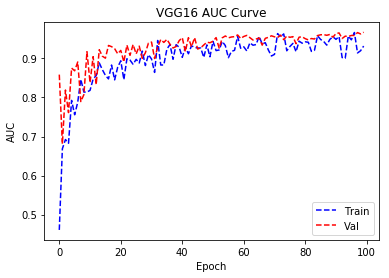

In [29]:
plt.plot(vgg_history.history['auc'],'b--')
plt.plot(vgg_history.history['val_auc'],'r--')
plt.title("VGG16 AUC Curve")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend(['Train','Val'],loc='lower right')
plt.savefig("Vgg_AUC_DataGenerator.svg")
plt.savefig("Vgg_AUC.jpeg")
plt.show()

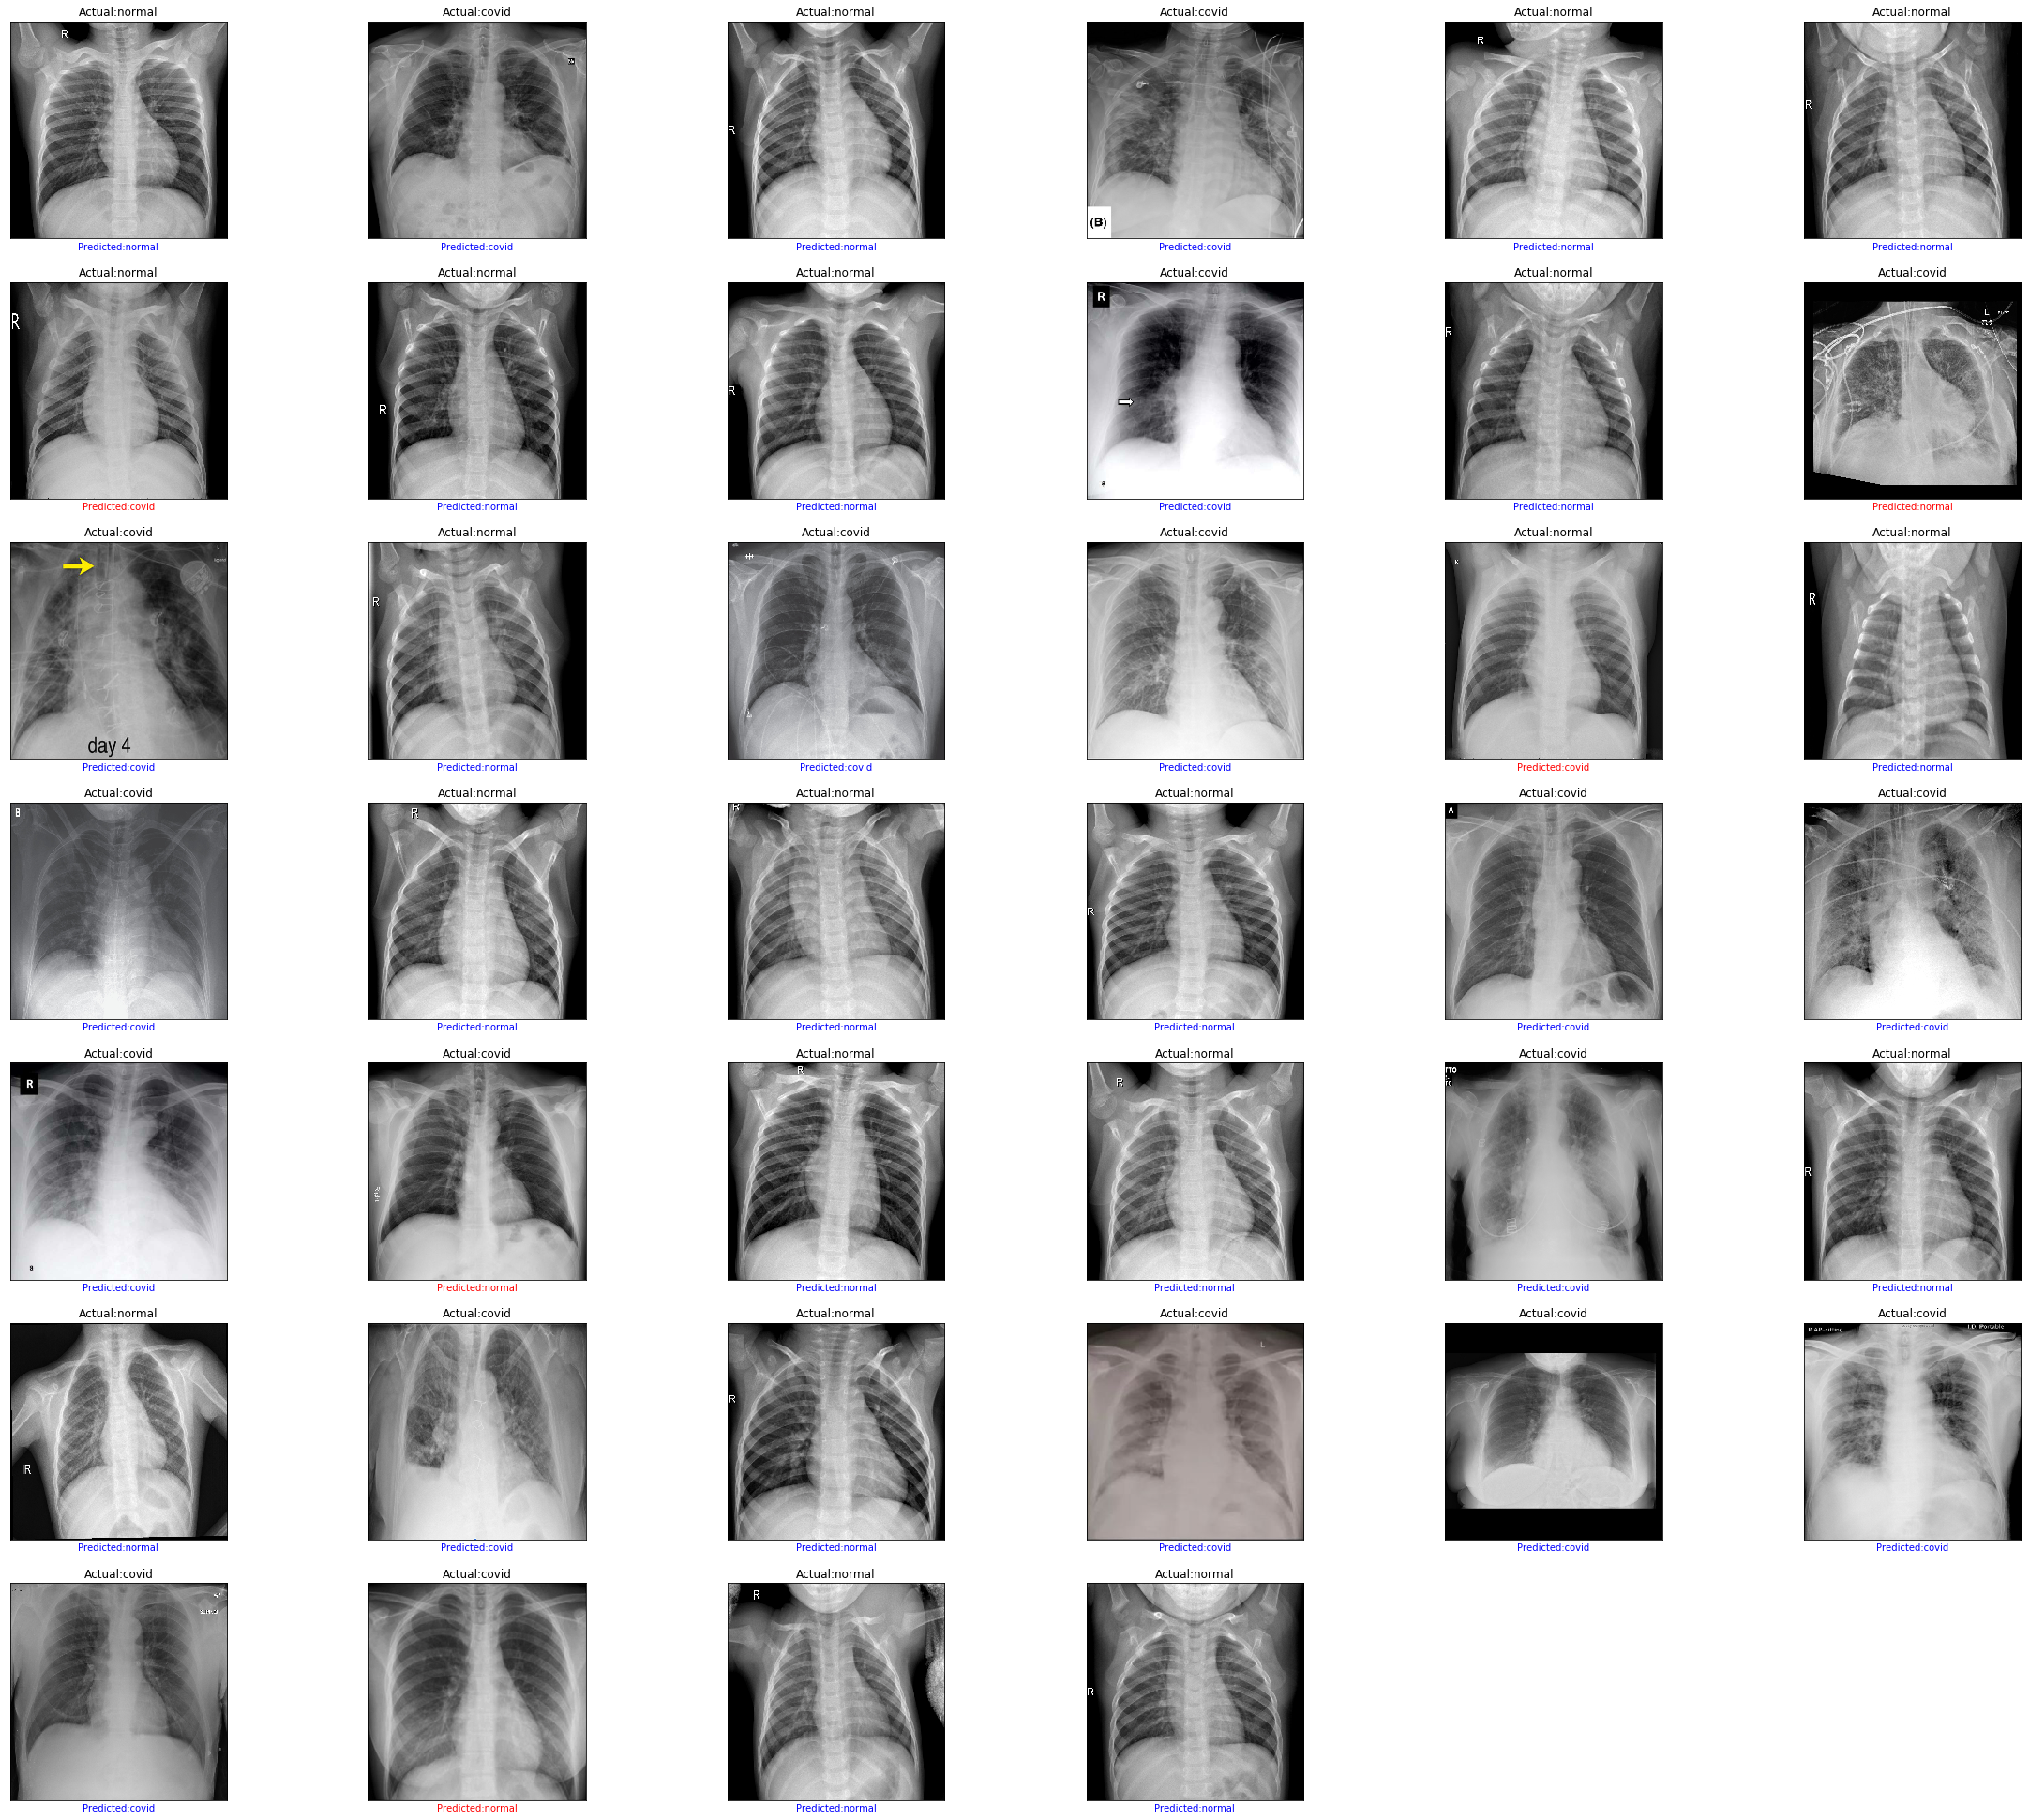

In [30]:
labels=['covid','normal']
plt.figure(figsize =(40,40))
for i in range(40):
    plt.subplot(8,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.show()

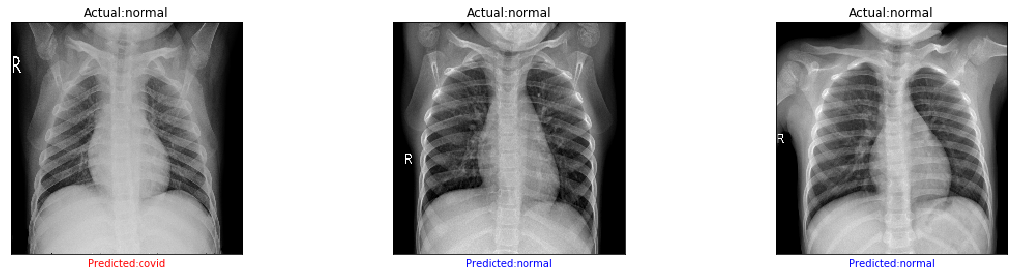

In [31]:
labels=['covid','normal']
plt.figure(figsize =(40,40))
for i in range(6,9,1):
    plt.subplot(8,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.savefig('vgg_model_test_imgae.svg')
plt.show()

# Creating FGSM ATTACK

In [32]:
loss_object = tf.keras.losses.BinaryCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

## For larger Epsilon

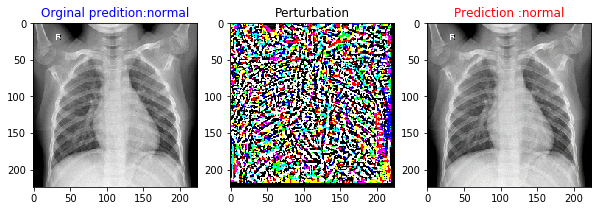

normal normal


In [33]:
k=27 #27 th image
eps=0.005 #larger epsilon value
image =testX[k].reshape(1,224,224,3)
image = tf.convert_to_tensor(image)
label = tf.convert_to_tensor(testY[k])
signed_grad = create_adversarial_pattern(image, label)
adversarial_image = testX[k]+(signed_grad*eps)
org_prediction = labels[np.argmax(model.predict(testX[k].reshape(1,224,224,3)))]
adversarial_prediction=labels[np.argmax(model.predict(adversarial_image))]
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title(f"Orginal predition:{org_prediction}",color='b')
plt.imshow(testX[k].reshape(224,224,3))
plt.subplot(1,3,2)
plt.title("Perturbation")
plt.imshow(signed_grad.numpy().reshape(224,224,3))
plt.subplot(1,3,3)
plt.title(f"Prediction :{adversarial_prediction}",color='r')
plt.imshow(adversarial_image.numpy().reshape(224,224,3))
plt.show()

print(org_prediction,adversarial_prediction)

In [34]:
import tensorflow as tf
tempered=[]
worked_eps=[]
correct_pred=[]
wrong_pred=[]
accuracy_correct_pred_on_that_eps=[]
total_n = len(testX)
final_probability=[]
final_org_prob=[]
diff_prob=[]
abs_prob=[]
epsilon=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009,0.01]

for eps in epsilon:
    probability=[]
    org_probability=[]
    count_adv=0
    vhul_count_adv=24
    for k in range(total_n):
        image =testX[k].reshape(1,224,224,3)
        image = tf.convert_to_tensor(image)
        label = tf.convert_to_tensor(testY[k])
        signed_grad = create_adversarial_pattern(image, label)        
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv=count_adv+1
            max_org=max(max(model.predict(testX[k].reshape(1,224,224,3))))
            max_prob = max(max(model.predict(adv_image.reshape(1,224,224,3))))
            probability.append(max_prob)
            org_probability.append(max_org)
        else:
            vhul_count_adv=vhul_count_adv+1
            tempered.append(k)
    worked_eps.append(eps)
    correct_pred.append(count_adv)
    wrong_pred.append(vhul_count_adv)
    acc = (count_adv/total_n)*100
    accuracy_correct_pred_on_that_eps.append(acc)
    try:
        
        org_prob = (sum(org_probability)/len(org_probability))*100
    except:
        org_prob = 0
    try:
        adv_prob = (sum(probability)/len(probability))*100
    except:
        adv_prob = 0
    diff_prob_overall= org_prob - adv_prob
    abs_diff_prob= abs(diff_prob_overall)
    final_org_prob.append(org_prob)
    final_probability.append(adv_prob)
    diff_prob.append(diff_prob_overall)
    abs_prob.append(abs_diff_prob)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
    print("Accuracy during eps = {} is {:.4f}".format(eps,acc))
    print("Average orginal probability during eps={} is {:.4f}".format(eps,org_prob))
    print("Average probability after adversarial during eps={} is {:.4f}".format(eps,adv_prob))
    print("Probability decrease of total images = {} during eps = {} is {:.4f}".format(len(probability),eps,diff_prob_overall))
    print("Absolute Probability decrease of total images = {} during eps = {} is {:.4f}".format(len(probability),eps,abs_diff_prob))

For epsilon : 0.0001
Numbers of Correct Prediction with Adversarial :  47
Numbers of Wrong Prediction with Adversarial :  31
Accuracy during eps = 0.0001 is 87.0370
Average orginal probability during eps=0.0001 is 96.8451
Average probability after adversarial during eps=0.0001 is 96.3646
Probability decrease of total images = 47 during eps = 0.0001 is 0.4805
Absolute Probability decrease of total images = 47 during eps = 0.0001 is 0.4805
For epsilon : 0.0003
Numbers of Correct Prediction with Adversarial :  47
Numbers of Wrong Prediction with Adversarial :  31
Accuracy during eps = 0.0003 is 87.0370
Average orginal probability during eps=0.0003 is 96.8451
Average probability after adversarial during eps=0.0003 is 95.2185
Probability decrease of total images = 47 during eps = 0.0003 is 1.6266
Absolute Probability decrease of total images = 47 during eps = 0.0003 is 1.6266
For epsilon : 0.0005
Numbers of Correct Prediction with Adversarial :  46
Numbers of Wrong Prediction with Adversari

In [35]:
data_list = {'Epsilon':worked_eps,
             'Correct Predict':correct_pred,
             'Wrong Predict':wrong_pred,
             'Accuracy':accuracy_correct_pred_on_that_eps,
             'Average Orginal Probability':final_org_prob,
             'Average Adversarial Probability':final_probability,
             'Probability Decrease By':diff_prob}
adversarial_dataframe_sars= pd.DataFrame(data_list)
adversarial_dataframe_sars.to_excel(r'WithNoise_Chest_VGG16_Augmentation_withPredictionDecrease.xlsx', sheet_name='Chest_VGG16_Augmentation', index = False)

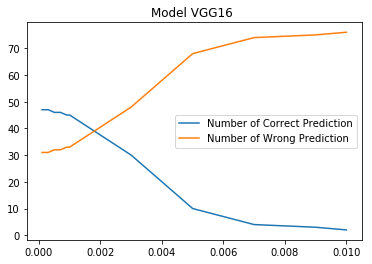

In [36]:
legend=['Number of Correct Prediction',"Number of Wrong Prediction"]
plt.plot(epsilon[:11],correct_pred[:11])
plt.plot(epsilon[:11],wrong_pred[:11])
plt.title("Model VGG16 ")
plt.legend(legend)
plt.savefig("VGG16_Performance_Drop.svg")
plt.savefig("VGG16_Performance_Drop.jpeg")
plt.show()

## Inception Can be used by only calling the pretrained model instead of VGG16
> This is just a review version of code for only Chest Xray
> All rights reserved to the Authors of the corresponding paper